In [4]:
# create conda -n [이름] python=[버전]
# conda activate [이름]
# conda deactivate
# conda remove -n [이름] --all

In [5]:
# 데이터 입력 -> 토큰화 및 시퀀스 변화 -> 패딩(고정길이화) -> 임베딩(단어 -> 벡터화) -> 1D (1차원) Convolution + poling 반복
# -> Flatten -> Dense (은닉층) -> 출력(소프트맥스, 이진분류) -> 학습(Adam + binary_Crossentropy)
# -> 검증/테스트 평가 -> 시각화

- 말뭉치 로딩(nltk) 데이터 로딩
- 토큰화(빈도 기반 인덱싱) 텍스트를 숫자로 변환
- 시퀀스 패딩 고정길이 배치 구성
- 임베딩 단어를 dense vector 표현 학습
- 임베딩 발전
    - 한계 : 작은 데이터에서는 일반화 부족을 겪을 수 있음
    - 발전 : 사전학습(Word2vec), 문맥적 임베딩(BERT, GPT)

In [6]:
import tensorflow as tf
print(tf.__version__)

2.20.0


In [7]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# sample data
texts = [
    'I really love this movie',
    'I hate this boring film',
    'love love great film'
]
# 토큰화 객체(최대 단어 10, oov 토큰 지정)
tokenizer = Tokenizer(num_words=10, oov_token='UNK')
tokenizer.fit_on_texts(texts)
print(f'단어인덱스 : {tokenizer.word_index}')
# 시퀀스
seqs = tokenizer.texts_to_sequences(texts)
print(f'원본 시퀀스 : {seqs}')
# 패딩(최대 길이를 6)
padded = pad_sequences(seqs, maxlen=6, padding='post')
print(f'패딩결과 : {padded} 사이즈 : {padded.shape}')

단어인덱스 : {'UNK': 1, 'love': 2, 'i': 3, 'this': 4, 'film': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'great': 10}
원본 시퀀스 : [[3, 6, 2, 4, 7], [3, 8, 4, 9, 5], [2, 2, 1, 5]]
패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]] 사이즈 : (3, 6)


In [8]:
tokenizer.word_docs

defaultdict(int,
            {'i': 2,
             'movie': 1,
             'really': 1,
             'love': 2,
             'this': 2,
             'boring': 1,
             'hate': 1,
             'film': 2,
             'great': 1})

In [9]:
# 임베딩 : 임베딩 레이어
import tensorflow as tf
# 패딩된 시퀀스 padded
vocab_size = 11 # unk 포함 단어 인덱스 최댓값 +1
embed_dim = 4   # 작은 차원
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=6)
])
embeddings = model.predict(padded)
print(f'임베딩 텐서 : {embeddings.shape}')  # 3,6,4
print(f'첫 문장 첫 단어 벡터 : {embeddings[0,0,:]}') 

c:\Users\sally\anaconda3\envs\p311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
임베딩 텐서 : (3, 6, 4)
첫 문장 첫 단어 벡터 : [ 0.04475225 -0.01015866 -0.01216056  0.00151683]


In [10]:
# 1D Convolution
import numpy as np
import tensorflow as tf
# 임의 시퀀스 생성(배치=1, 길이=6, 임베딩=4)
x = np.random.rand(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
    filters = 2  # 2개의 패턴을 감지
    ,kernel_size = 3    #3-gram
    ,activation = 'relu'
)
y = conv(x)
print(f'입력 shape {x.shape}')
print(f'출력 shape {y.shape}')
print(f'출력값 shape {y.numpy()}')

입력 shape (1, 6, 4)
출력 shape (1, 4, 2)
출력값 shape [[[0.         0.        ]
  [0.         0.13241081]
  [0.         0.13479161]
  [0.         0.        ]]]


In [11]:
# MaxPooling 
pool = tf.keras.layers.MaxPooling1D(pool_size=2)
pooled = pool(y)
print(f'before pooling : {y.shape}')
print(f'after pooling : {pooled.shape}')

before pooling : (1, 4, 2)
after pooling : (1, 2, 2)


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  #길이 맞추기
texts = [
    'I really love this movie',  # 긍정
    'I hate this boring film',  # 부정
    'great love movie',  # 긍정
    'boring hate film' # 부정
]
labels = np.array([0,1,0,1])

tokenizer = Tokenizer(num_words=50,oov_token='UNK')
tokenizer.fit_on_texts(texts)  # 단어사전 생성
seqs =  tokenizer.texts_to_sequences(texts)  # 단어사전기반으로 단어들을 숫자로 변경(길이는 다름)
x = pad_sequences(seqs,maxlen=6,padding='post')
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(50,8,input_length=6),
    tf.keras.layers.Conv1D(16,3,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
history =model.fit(x,labels,epochs=15)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - acc: 0.5000 - loss: 0.6909
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.5000 - loss: 0.6896
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - acc: 0.5000 - loss: 0.6884
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.5000 - loss: 0.6874
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - acc: 0.5000 - loss: 0.6865
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.5000 - loss: 0.6855
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.7500 - loss: 0.6844
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.7500 - loss: 0.6833
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - acc: 0.7500 - loss: 0.6821
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 0.7500 - loss: 0.6809
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.7500 - loss: 0.6796
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.7500 - loss: 0.6783
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - acc: 0.750

In [13]:
print(f"최종 훈련 정확도 : {history.history['acc'][-1]}")
preds = model.predict(x)
print(preds)
print(f'라벨 : {labels}')

최종 훈련 정확도 : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
[[0.4947271 ]
 [0.5179774 ]
 [0.49833462]
 [0.5171267 ]]
라벨 : [0 1 0 1]


In [14]:
# nltk 데이터로드
import nltk 
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sally\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [15]:
# 재현성 시드 고정
import random 
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [16]:
# 데이터 로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

In [17]:
categories

['neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',


In [18]:
# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    # tf.keras.layers.GlobalAvgPool1D()  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

Epoch 1/15


c:\Users\sally\anaconda3\envs\p311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - acc: 0.5336 - loss: 0.6982 - val_acc: 0.5437 - val_loss: 0.6901
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - acc: 0.4891 - loss: 0.6949 - val_acc: 0.5437 - val_loss: 0.6925
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - acc: 0.5180 - loss: 0.6923 - val_acc: 0.5188 - val_loss: 0.6926
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - acc: 0.5414 - loss: 0.6909 - val_acc: 0.5562 - val_loss: 0.6903
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - acc: 0.6195 - loss: 0.6893 - val_acc: 0.5219 - val_loss: 0.6900
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - acc: 0.5383 - loss: 0.6868 - val_acc: 0.5188 - val_loss: 0.6919
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - acc: 0.5523 - loss: 0.6811 - val_acc: 0.5250 - val_loss: 0.6906
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - acc: 0.5883 - loss: 0.6714 - val_acc: 0.5281 - val_loss: 0.6891
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 876ms/step - acc: 0.6586 - loss: 0.6487 - va

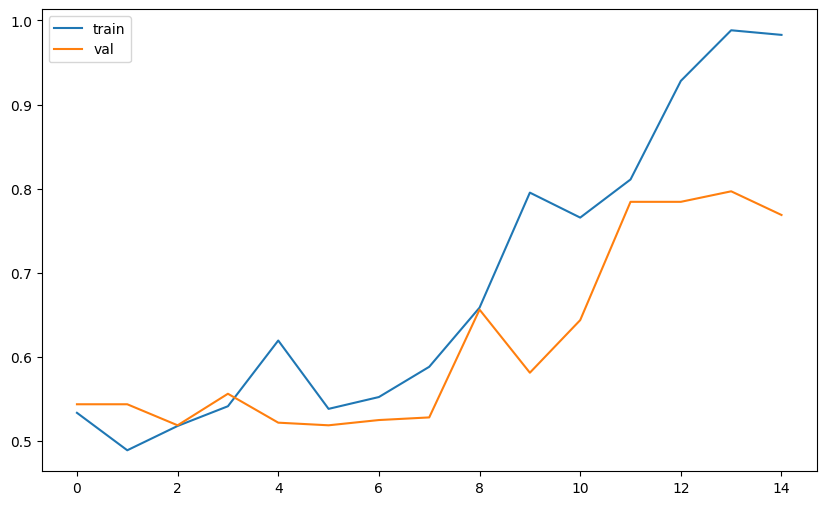

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - acc: 0.7100 - loss: 0.6650
test loss : 0.6650201678276062  test acc : 0.7099999785423279


In [19]:
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')
# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

In [20]:
# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample, maxlen=maxlen, truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


array([[0.9913461 ],
       [0.99407554]], dtype=float32)

In [21]:
# conv1d 배치크기, 시퀀스 길이, 채널 수 
x = tf.random.normal((32,10,64))
print(tf.keras.layers.Flatten()(x).shape)
tf.keras.layers.GlobalAvgPool1D()(x).shape  # 각 채널 Feature map 마다 평균

(32, 640)


TensorShape([32, 64])

GlobalMaxPooling 사용 (파라메터 감소)
- Flatten 대신 GlobalMaxPooling1D 각 필터의 최대값만 추출해서 파라메터 수를 감소
- 토크나이저 - 시퀀스 - 패딩 --> X
- 라벨링 --> y
- 분할
- 모델 ...Flatten GlobalMaxPool1D

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sally\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Epoch 1/14


c:\Users\sally\anaconda3\envs\p311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 552ms/step - acc: 0.5039 - loss: 0.6969 - val_acc: 0.4563 - val_loss: 0.6984
Epoch 2/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - acc: 0.5555 - loss: 0.6850 - val_acc: 0.5625 - val_loss: 0.6926
Epoch 3/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - acc: 0.7500 - loss: 0.6797 - val_acc: 0.4563 - val_loss: 0.6949
Epoch 4/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 863ms/step - acc: 0.5641 - loss: 0.6713 - val_acc: 0.4563 - val_loss: 0.6954
Epoch 5/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 946ms/step - acc: 0.7312 - loss: 0.6603 - val_acc: 0.4594 - val_loss: 0.6932
Epoch 6/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - acc: 0.9445 - loss: 0.6467 - val_acc: 0.4563 - val_loss: 0.6931
Epoch 7/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - acc: 1.0000 - loss: 0.6271 - val_acc: 0.6500 - val_loss: 0.6898
Epoch 8/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - acc: 1.0000 - loss: 0.6023 - val_acc: 0.6187 - val_loss: 0.6884
Epoch 9/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - acc: 1.0000 - loss: 0.5680 - va

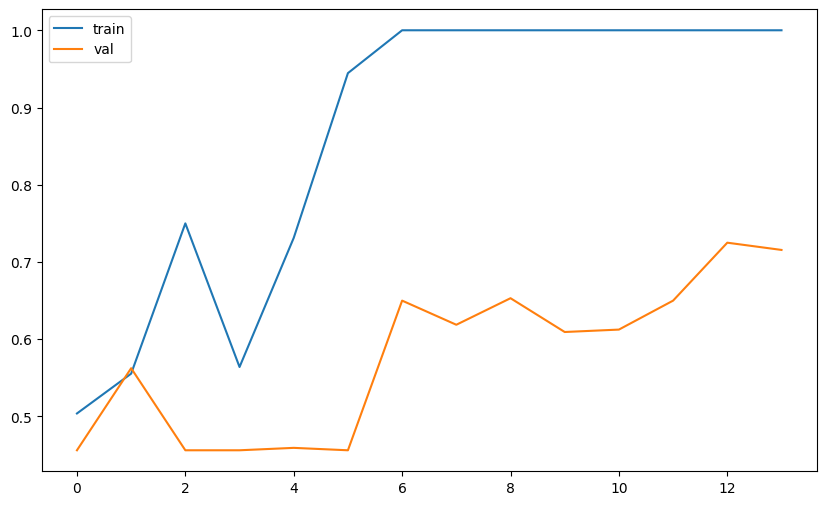

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.6975 - loss: 0.6397
test loss : 0.6396572589874268  test acc : 0.6974999904632568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


array([[0.66426265],
       [0.6329241 ]], dtype=float32)

In [22]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [ movie_reviews.categories(id)[0] for id in ids]

# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 14 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

개선 2: 다중 커널 크기 병렬 적용 (TextCNN)
- 커널 크기 3 5 7 동시에 사용 다양한 tri-gram 5-gram 7-gram 포착


Epoch 1/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 707ms/step - acc: 0.5109 - loss: 0.6977 - val_acc: 0.4563 - val_loss: 0.6967
Epoch 2/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 721ms/step - acc: 0.7430 - loss: 0.6758 - val_acc: 0.5437 - val_loss: 0.6888
Epoch 3/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - acc: 0.9195 - loss: 0.6650 - val_acc: 0.4563 - val_loss: 0.6922
Epoch 4/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 853ms/step - acc: 0.7523 - loss: 0.6497 - val_acc: 0.4563 - val_loss: 0.6927
Epoch 5/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 921ms/step - acc: 0.9961 - loss: 0.6309 - val_acc: 0.5938 - val_loss: 0.6868
Epoch 6/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - acc: 1.0000 - loss: 0.6081 - val_acc: 0.7000 - val_loss: 0.6821
Epoch 7/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 880ms/step - acc: 1.0000 - loss: 0.5784 - val_acc: 0.6969 - val_loss: 0.6766
Epoch 8/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 795ms/step - acc: 1.0000 - loss: 0.5393 - val_acc: 0.7563 - val_loss: 0.6658
Epoch 9/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step - acc: 1.0000 - loss: 

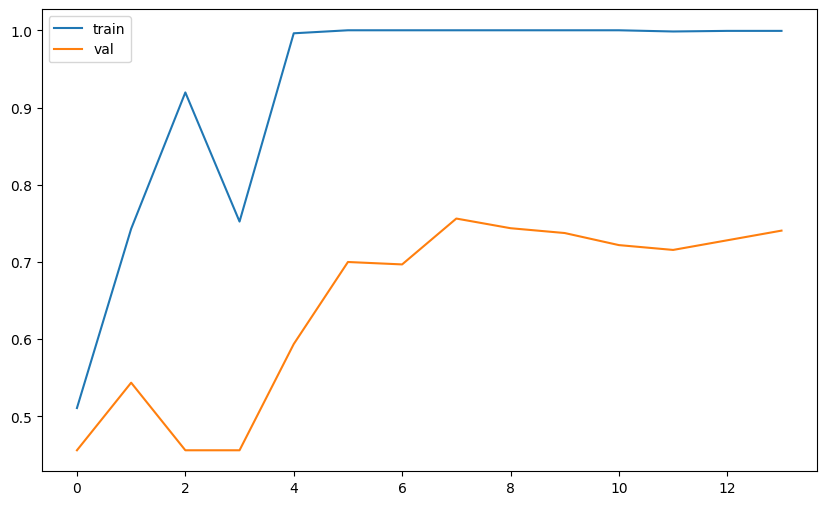

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.7200 - loss: 0.5601
test loss : 0.5600597858428955  test acc : 0.7200000286102295
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


array([[0.560223],
       [0.569765]], dtype=float32)

In [23]:
from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,kener_size,activation='relu')(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(64,activation='relu')(concat)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

Pretrained Embeddings(GloVe)로 초기화

| 구분 | Word2Vec | GloVe |
|------|-----------|--------|
| **학습 방식** | 예측 기반 (Predictive) | 통계 기반 (Count-based) |
| **핵심 아이디어** | 단어 주변 문맥 예측 | 단어 간 동시출현 확률(전체 코퍼스 통계) 사용 |
| **대표 모델** | Skip-Gram, CBOW | Global Vectors (GloVe) |


In [24]:
import gensim.downloader as api
import numpy as np
# GloVe모델 50차원
wv = api.load('glove-wiki-gigaword-50')

In [25]:
# 우리 데이터셋에서 사용되는 단어들을
# GloVe가 이미 학습한 벡터로 연결해서
# Embedding Laye 의 가중치 초기값으로 사용하기 위해 embedding_matrix를 만드는 것.
wv['king'].shape    # 50차원

(50,)

매칭 : 9722 비매칭 : 277
커버리지 : 0.9722972297229723


c:\Users\sally\anaconda3\envs\p311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - acc: 0.4852 - loss: 0.8261 - val_acc: 0.4563 - val_loss: 0.7695
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - acc: 0.5578 - loss: 0.6848 - val_acc: 0.5437 - val_loss: 0.6897
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.5125 - loss: 0.6850 - val_acc: 0.4563 - val_loss: 0.7084
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - acc: 0.5844 - loss: 0.6613 - val_acc: 0.5719 - val_loss: 0.6807
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - acc: 0.7203 - loss: 0.6517 - val_acc: 0.5625 - val_loss: 0.6850
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - acc: 0.7250 - loss: 0.6357 - val_acc: 0.6281 - val_loss: 0.6773
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - acc: 0.9422 - loss: 0.6199 - val_acc: 0.6500 - val_loss: 0.6749
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - acc: 0.8914 - loss: 0.6039 - val_acc: 0.6406 - val_loss: 0.6686
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - acc: 0.9680 - loss: 0.5850 - 

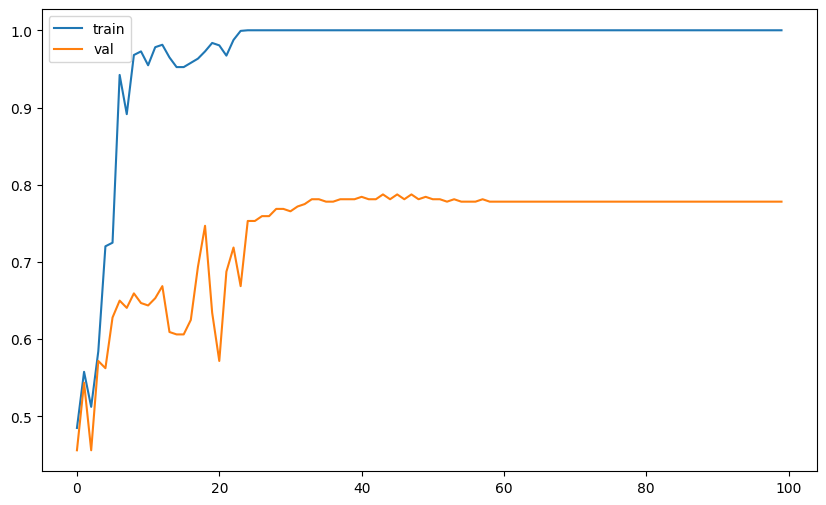

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.7850 - loss: 0.6525
test loss : 0.6525484323501587  test acc : 0.7850000262260437
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


array([[0.03347946],
       [0.7489821 ]], dtype=float32)

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  #길이 맞추기 

# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 50 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
import numpy as np
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)

# 임베딩 매트릭스 초기화
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)+1)
embedding_matrix = np.random.normal(
    loc = 0.0, scale=0.1,size =(num_words, embed_dim)
)

# glove 매칭
hits = 0
misses = 0
for word, i in word_index.items():
    if i >= max_words:
        continue
    try:
        embedding_vector = wv[word]      # GloVe에서 단어 벡터 찾기
        embedding_matrix[i] = embedding_vector  # 해당 위치에 저장
        hits += 1
    except KeyError:
        misses += 1
print(f'매칭 : {hits} 비매칭 : {misses}')        
print(f'커버리지 : {hits / (hits+misses)}')

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words,output_dim=embed_dim,input_length=maxlen,
                              weights=[embedding_matrix] ),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=100,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

다중커널(3 5 7) + 드랍아웃 + L2 정규화

Epoch 1/15


c:\Users\sally\anaconda3\envs\p311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - acc: 0.4906 - loss: 1.0071 - val_acc: 0.4563 - val_loss: 0.9883
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - acc: 0.5258 - loss: 0.9574 - val_acc: 0.4563 - val_loss: 0.9459
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - acc: 0.7039 - loss: 0.9155 - val_acc: 0.6344 - val_loss: 0.9112
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - acc: 0.7773 - loss: 0.8799 - val_acc: 0.4812 - val_loss: 0.8840
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - acc: 0.7633 - loss: 0.8469 - val_acc: 0.4563 - val_loss: 0.8598
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - acc: 0.8219 - loss: 0.8169 - val_acc: 0.5531 - val_loss: 0.8365
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - acc: 0.8984 - loss: 0.7884 - val_acc: 0.6719 - val_loss: 0.8128
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - acc: 0.9250 - loss: 0.7612 - val_acc: 0.6656 - val_loss: 0.7891
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - acc: 0.8562 - loss: 0.7299 - va

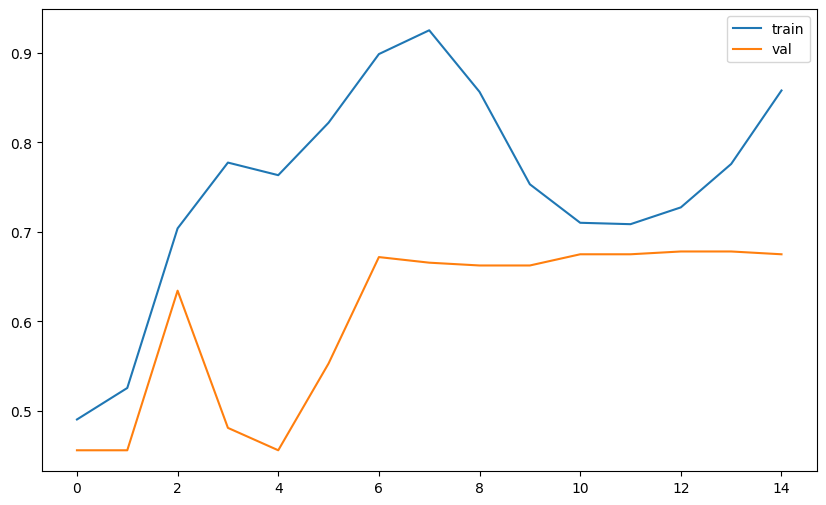

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.6525 - loss: 0.6961
test loss : 0.696052074432373  test acc : 0.6524999737739563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


array([[0.45897394],
       [0.47464237]], dtype=float32)

In [28]:
from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(
        128,
        kener_size,
        activation='relu',
        kernel_regularizer = tf.keras.regularizers.l2(1e-3)
        )(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(128,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                              )(concat)
dense = tf.keras.layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(64,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                              )(concat)
dense = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict